In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
files_path = './data/'

In [2]:
# get all probabilities with foul
def make_players_prob_df(df):
    # filtrado para tener solo linea defensiva
    df = df[df.pff_role == 'Pass Block']
    # get all player's id
    #players = df.nflId.tolist()
    players = pd.unique(df.nflId)
    p_df = pd.DataFrame(columns=['nflId','pff_beatenByDefender_P','pff_hitAllowed_P','pff_hurryAllowed_P','pff_sackAllowed_P','foul1','foul2','foul3'])
    for player in players:
        aux = df[df.nflId == player]
        aux = aux.drop_duplicates(subset=['playId'])
        aux = aux[['pff_beatenByDefender','pff_hitAllowed','pff_hurryAllowed','pff_sackAllowed','foul1','foul2','foul3']]
        p_aux = pd.DataFrame({'nflId':player,
                             'pff_beatenByDefender_P':aux.pff_beatenByDefender.sum()/aux.shape[0],
                             'pff_hitAllowed_P':aux.pff_hitAllowed.sum()/aux.shape[0],
                             'pff_hurryAllowed_P':aux.pff_hurryAllowed.sum()/aux.shape[0],
                             'pff_sackAllowed_P':aux.pff_sackAllowed.sum()/aux.shape[0],
                             'foul1':aux.foul1.sum()/aux.shape[0],
                             'foul2':aux.foul2.sum()/aux.shape[0],
                             'foul3':aux.foul3.sum()/aux.shape[0]
                              },index=[0])
        p_df = pd.concat([p_df,p_aux])
    return p_df

In [3]:
# function to get final value
def get_metric_value(df,sf):
    '''inputs: 
        df -> dataframe with 'pff_beatenByDefender_P','pff_hitAllowed_P','pff_hurryAllowed_P','pff_sackAllowed_P','foul1','foul2','foul3' columns
        sf -> scale factor value
    '''
    aux = make_players_prob_df(df)
    aux['p_sum'] = aux[['pff_beatenByDefender_P','pff_hitAllowed_P','pff_hurryAllowed_P','pff_sackAllowed_P','foul1','foul2','foul3']].sum(axis=1)
    aux['p_sum_scaled'] = aux['p_sum']*sf
    return aux

In [4]:
def set_level(olpf):
    if olpf <= max_psum and olpf >=end_medium:
        level = 'HIGH'
    elif olpf <= end_medium and olpf >=start_medium:
        level = 'MEDIUM'
    elif olpf <= start_medium and olpf >=min_psum:
        level = 'LOW'
    return level

In [5]:
#os.listdir(files_path)
df_all = pd.read_csv(files_path+'pffScoutingData.csv')
df_p = pd.read_csv(files_path+'plays.csv')
player_df = pd.read_csv(files_path+'players.csv')

# Big Data Bowl 2023  

## Offensive Line Probability of Failure

How do we know if a player on the offensive line is as good as we need? We can evaluate a player if he has a good performance, if a player can stop defense most of the time. With this, we know that the player will miss some occasions, but, how many misses are enough? How do we know if a player has an acceptable, poor or outstanding performance?

With Offensive Line Probability of Failure (OLPF) we can know the performance of every offensive player on the line.

OLPF is a metric that evaluates the performance of offensive line players in a game or even in a season. Taking all plays in a game and evaluating if a play performed well or poorly based on some variables that all players on the line have.

## Objectives
   
   * Evaluate the probability of failure of individual players to know the performance during one or more games  
   * Know the distribution of the players of a team based on the probability of failure (OLPF) of the players that make up the team

# Variables Used
 To calculate OLPF (Ofensive Line Probability Failure), we will use all data containing information about each fail play of every player. To know if play counts as fail to player, we will take every time a player allowed a sack, hit or hurry.  

Also, we will take if player where beaten by defender or if player made a foul, although it means the play did not end as sack, hurry or hit, it means that offensive line player failed to achieve the goal of his position.  

All data used takes only two values, 1 if is true; 0 if is false.  
  
<font size="4">**HTA - Hit Allowed**</font>
   * Indicator for whether a player is responsible for a hit on the QB
 

<font size="4">**HYA - Hurry Allowed**</font>


   * Indicator for whether a player is responsible for a hurry on the QB
  
<font size="4">**SKA - Sack Allowed** </font>

   * Indicator for whether a player is responsible for a sack on the QB
 

<font size="4"> **F1 - Foul1** </font>

   * If player committed first foul during the play
 
  
<font size="4"> **F2 - Foul2** </font>

   * If player committed second foul during the play
 
   
<font size="4"> **F3 - Foul3**</font>

   * If player commits a thirt foul during the play
     


In [6]:
# adding foul name and nflid
for i in range(1,4):
    foul_name = 'foulName'+str(i)
    foul_nflid =  'foulNFLId'+str(i)
    poss_team = 'possessionTeam'+str(i)
    #aux_p = df_p[['playId',foul_name,foul_nflid]]  
    aux_p = df_p[['playId','possessionTeam',foul_name,foul_nflid]]  
    aux_p = aux_p.rename(columns={'possessionTeam':poss_team})
    aux_p = aux_p[aux_p.playId.isin(df_all.playId.tolist())]
    df_all = df_all.merge(aux_p,how='left',left_on=['playId','nflId'],right_on=['playId',foul_nflid])

In [7]:
df_all['foulName1'] = df_all['foulName1'].fillna('')
df_all['foulName2'] = df_all['foulName2'].fillna('')
df_all['foulName3'] = df_all['foulName3'].fillna('')
df_all['foul1'] = df_all.apply(lambda x: 0 if x['foulName1']=='' else 1, axis=1)
df_all['foul2'] = df_all.apply(lambda x: 0 if x['foulName2']=='' else 1, axis=1)
df_all['foul3'] = df_all.apply(lambda x: 0 if x['foulName3']=='' else 1, axis=1)

## Criteria:
   * Scale factor must consider at least 95% of probability of failure of all players  
   * Player must have at least 30 registered plays  
   * All plays must be unique for each player  
   * All data must be from offensive fully blocking a defender
 

In [8]:
# selecting data that complies with the conditions of use
df_all = df_all.drop_duplicates(subset=['nflId','playId'],keep='last')
df_aux = df_all.nflId.value_counts().rename_axis('nflId').reset_index(name='counts')
df_aux = df_aux[df_aux.counts > 30]

df_all = df_all[df_all.nflId.isin(df_aux.nflId.tolist())]
df_all = df_all[df_all.pff_role == 'Pass Block']

## Model

A simple model was generated using all plays where the target player was to get the probability of miss in every variable. Since all variables are mutually exclusive events, the offensive line probability of failure metric ***OLPF*** is the sum of all probabilities as is shown in the formula below.


$$OLPF = \left ( P(HTA) + P(HYA) + P(SKA) + P(F1) + P(F2) + P(F3) \right ) \ast \beta $$

In terms of total plays and their results, the formula can be expressed as below  

$$OLPF = \left ( \frac{HTA}{TP} + \frac{HYA}{TP} + \frac{SKA}{TP} + \frac{F1}{TP} + \frac{F2}{TP} + \frac{F3}{TP} \right )\ast \beta $$

where $\beta$ is a scale factor

In [9]:
df = df_all
pro_df = make_players_prob_df(df)
pro_df['p_sum'] = pro_df[['pff_beatenByDefender_P','pff_hitAllowed_P','pff_hurryAllowed_P','pff_sackAllowed_P','foul1','foul2','foul3']].sum(axis=1)

## Selecting Scale Factor  

Scale factor will be used to show the metric in a range between 0 to 10  
  
  
We will get the value of scale factor with a simple formula  
  
$$\beta = \frac{1}{q} * 100$$  

where ***q***  is maximum value until selected percentage of data


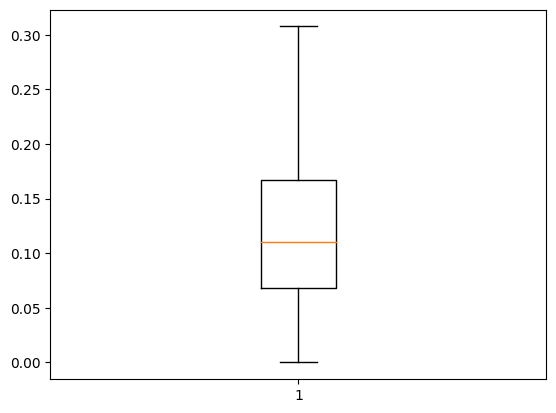

In [10]:
# Deleting outliers to get scale factor value
bp = plt.boxplot(pro_df['p_sum'],showfliers=False)
maxx = bp['caps'][1].get_ydata()[0]
pro_df= pro_df[pro_df['p_sum'] <= maxx]

In [11]:
# Getting scale factor
q = 1 # quantile
s_f = (1/pro_df.quantile(q=q).p_sum) * 100
print("Sclae factor value: ",s_f)

Sclae factor value:  325.0


The result of the probability of failure of all players is shown below

In [12]:
#pro_df['p_sum'] = pro_df['p_sum'] * s_f
pro_df[['pff_beatenByDefender_P', 'pff_hitAllowed_P',
       'pff_hurryAllowed_P', 'pff_sackAllowed_P', 'foul1', 'foul2', 'foul3',
       'p_sum']] = pro_df[['pff_beatenByDefender_P', 'pff_hitAllowed_P',
       'pff_hurryAllowed_P', 'pff_sackAllowed_P', 'foul1', 'foul2', 'foul3',
       'p_sum'] ]* s_f

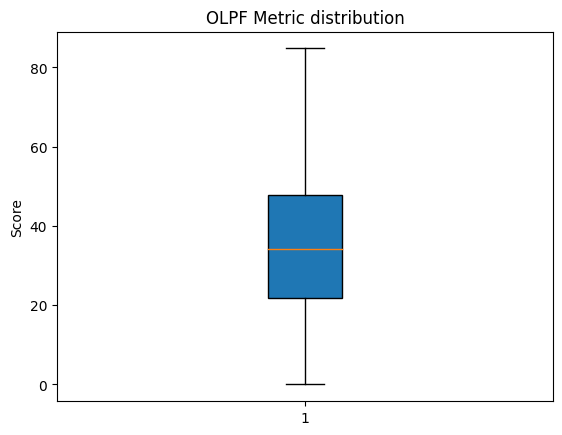

In [13]:
bp = plt.boxplot(pro_df['p_sum'],showfliers=False,patch_artist=True)
plt.title('OLPF Metric distribution')
plt.ylabel('Score')
median = bp['medians'][0].get_ydata()
max_psum = bp['caps'][1].get_ydata()[0]
min_psum = bp['caps'][0].get_ydata()[0]
end_medium = bp['whiskers'][1].get_ydata()[0]
start_medium = bp['whiskers'][0].get_ydata()[0]

In this case that we are measuring a metric of player failures, we can use a box plot to take advantage of the ranges shown and use them as indicators as described below.

**Levels of OLPF**  

**Low**
   * When OLPF is in the range of Lowest general Score to Q1, this means the performance was outstanding
  
**Medium**
   * When OLPF is in the range of Q1 to Q3, this means the performance was good
 
**High**

   * When OLPF is in the range of Q3 to max in general score, this means the performance was poor

## Verifying the number of levels

We use the three different areas of the boxplot to create the OLPF levels based on the common use of 3 levels to measure a metric (low, medium and high).
But for this case, we must have the levels based on the same information that the data gives us.
For that, we will use the elbow technique with kmeans to know the number of clusters (levels) we need for the metric.

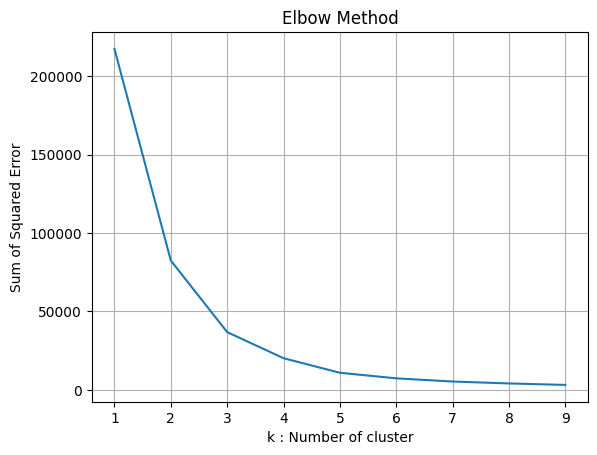

In [14]:
sse = {}
sil = []
kmax = 10
fig = plt.subplots(nrows = 1, ncols = 1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(pro_df['p_sum'].to_numpy().reshape(-1,1))
    sse[k] = kmeans.inertia_ 
plt.plot(list(sse.keys()),list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()
plt.show()

The graph above show that the sum of squared error changes drastically until have 3 clusters, from there the change is much less, so we can say that the optimum number of clusters is three  

Now, let's see where is the position of the clusters

In [15]:
modelo_kmeans = KMeans(n_clusters=3, n_init=25, random_state=123)
modelo_kmeans.fit(pro_df['p_sum'].to_numpy().reshape(-1,1))

KMeans(n_clusters=3, n_init=25, random_state=123)

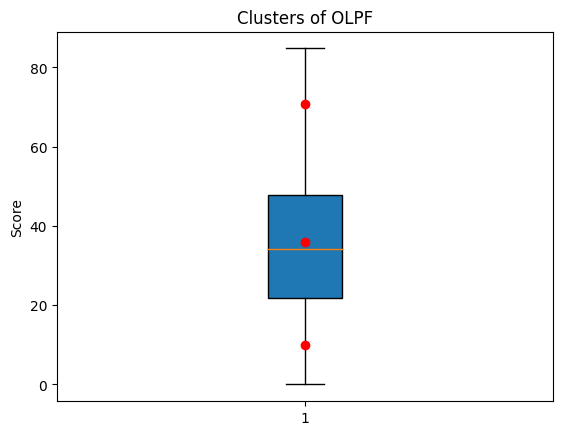

In [16]:
plt.boxplot(pro_df['p_sum'].to_numpy().reshape(-1,1),showfliers=False,patch_artist=True)
plt.plot(np.ones(3),modelo_kmeans.cluster_centers_,'ro')
plt.title('Clusters of OLPF')
plt.ylabel('Score')
plt.show()

## Using the model

### Rating player performance

In this case of use we will check the OLPF in a week and in 8 weeks

#### Performance in week 1

In [17]:
# Rating player performance first week
df_w = pd.read_csv(files_path+'week1.csv')

In [18]:
# target player
player_df[player_df.nflId == 53471]

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
1507,53471,6-6,308,NaN,NaN,T,Liam Eichenberg


In [19]:
# getting all playId from week1 with nflId
w1_plays = pd.unique(df_w[df_w.nflId == 53471]['playId']).tolist()
# extract pffScoutingData with all playIds 
week1 = df_all[(df_all.playId.isin(w1_plays)) & (df_all.nflId == 53471 )]

In [20]:
p_sum = get_metric_value(week1,s_f)['p_sum_scaled'][0]
p_sum = [p_sum]
p_sum

[68.42105263157895]

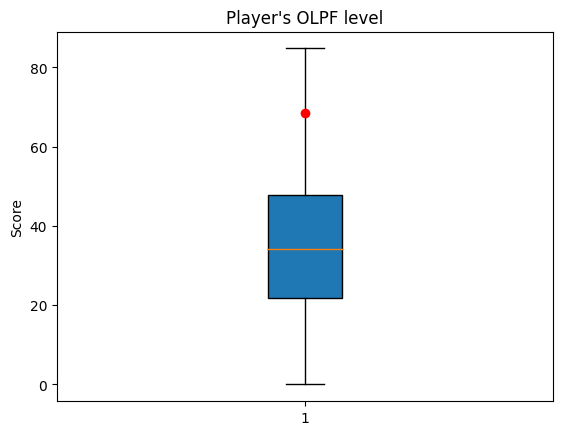

In [21]:
plt.boxplot(pro_df['p_sum'].to_numpy().reshape(-1,1),showfliers=False,patch_artist=True)
plt.plot(np.ones(len(p_sum)),p_sum,'ro')
plt.title("Player's OLPF level")
plt.ylabel('Score')
plt.show()

**How to read**  

As we can see, metric of target player is in high section, this means that player had a bad performance in target week  

To this metric, we want score as low as possible to be a outstanding player, but if the OLPF falls into medium level (and it will be like this most of the time) it's also good

#### Performance in 8 weeks

In [22]:
weeks_df_list = list()
nflid = 53471
for i in range(1,9):
    df = pd.read_csv(files_path+'week'+str(i)+'.csv')
    df = df[df.nflId == nflid]
    # getting all playId from week1 with nflId
    w_plays = pd.unique(df[df.nflId == nflid]['playId']).tolist()
    # extract pffScoutingData with all playIds 
    week = df_all[(df_all.playId.isin(w_plays)) & (df_all.nflId == nflid )]
    df = get_metric_value(week,s_f)['p_sum_scaled'].to_frame()
    df['week'] = i
    weeks_df_list.append(df)
    if i == 8:
        df = pd.concat(weeks_df_list)
        
        

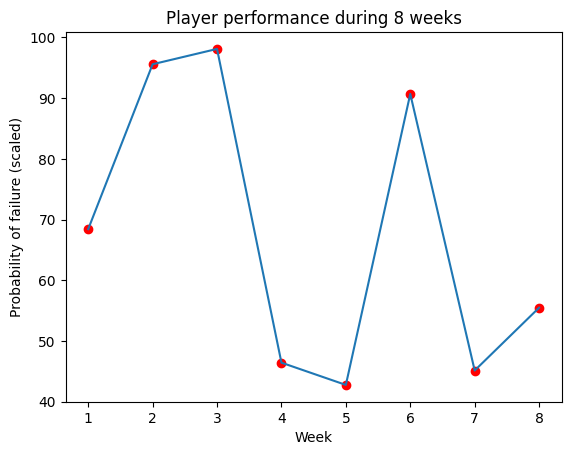

In [23]:
plt.plot(df.week,df.p_sum_scaled,'ro')
plt.plot(df.week,df.p_sum_scaled)
plt.title(r'Player performance during 8 weeks')
plt.xlabel('Week')
plt.ylabel('Probability of failure (scaled)')
plt.show()

Player's OLPF (as we can expect) in some cases is better than other ones, but in most cases is a high score, let's see mean

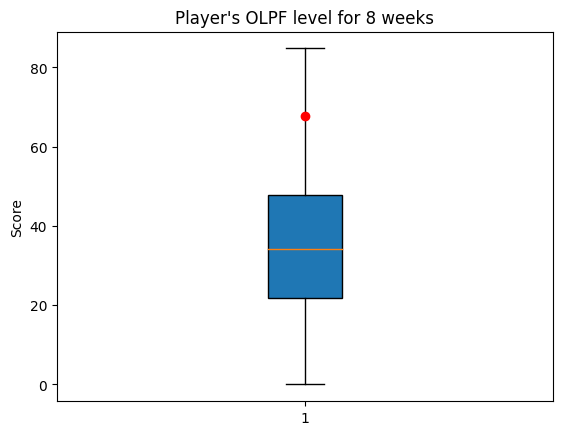

In [24]:
player_mean = df.describe().iloc[1]['p_sum_scaled']

x0 = [player_mean]

plt.boxplot(pro_df['p_sum'].to_numpy().reshape(-1,1),showfliers=False,patch_artist=True)
plt.plot(np.ones(len(x0)),x0,'ro')
plt.title("Player's OLPF level for 8 weeks")
plt.ylabel('Score')
plt.show()

As we can see, the mean for the 8 weeks is **67.8** and this is over the 75% OLPF. With this now we know player needs to improve his performance during plays

### Team players ranking

In [25]:
test_df = pro_df.copy()

In [26]:
# getting team per nflId
for j in range(1,9):
    if j==1:
        df_w = pd.read_csv(files_path+'week'+str(j)+'.csv')
        pass
    else:
        df_aux = pd.read_csv(files_path+'week'+str(j)+'.csv')
    df_w = pd.concat([df_w,df_aux])

In [27]:
df_w = df_w.drop_duplicates(subset=['nflId'],keep='last')
df_w = df_w[['nflId','team']]
team_p = test_df.merge(df_w,on='nflId')
team_p = team_p[~team_p.team.isna()]
player_df = player_df[['nflId','displayName']]
team_p = team_p.merge(player_df,on='nflId')

In [28]:
mia_df = team_p[team_p.team == 'MIA'].sort_values(by='p_sum',ascending=False)[['displayName','p_sum']]
mia_df = mia_df.rename(columns={'p_sum':'OLPF'})
mia_df

,displayName,OLPF
205,Myles Gaskin,79.054054
202,Liam Eichenberg,67.805755
198,Jesse Davis,65.909091
302,Austin Jackson,58.362676
201,Solomon Kindley,48.750000
301,Durham Smythe,39.000000
345,Adam Shaheen,32.500000
200,Robert Hunt,31.105611
392,Austin Reiter,29.545455
199,Michael Deiter,22.608696


In [29]:
mia_df['level'] = ''

In [30]:
mia_df['level'] = mia_df.OLPF.map(lambda x: set_level(x))

In [31]:
mia_pie = mia_df.groupby('level').count()[['displayName']]

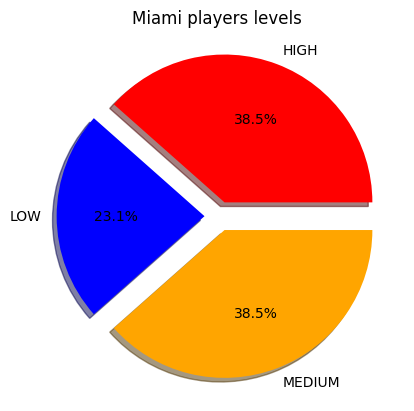

In [32]:
explode = (0.1, 0.1, 0.1)
colors = ['red','blue','orange']
plt.pie(mia_pie['displayName'].tolist(), explode=explode,labels=mia_pie.index, autopct='%1.1f%%',
        shadow=True,colors=colors)
plt.title("Miami players levels ")
plt.show()

The chart above shows how the offensive line of the Miami Dolphins is made up of 38.5% of players who fall into a high level of failures in the plays, clearly it would be expected to be at least equal to the percentage of outstanding players to have a strong enough line that can successfully execute plays most of the time

## Conclusions

A metric has been obtained that measures the performance of the offensive line players based on the failures rather than the successes of the plays, this allows having a larger window of information, for example, the fouls committed by the players have been taken into account since the player has not been defeated by a defender and has not allowed a sack, hit or hurry but the play has not been successful and this is due to the foul committed by the player. So the metric is not being biased by the lack of information.

For this metric there is a consideration to take into account.

To obtain an accurate score, a sufficient amount of data is needed; in this case a minimum of 30 records were used. This to avoid false scores, for example, if it is applied to players who have only 10 recorded moves and have not had any failure, it would get an outstanding score. This type of bias introduces errors in the analysis when compared with other players where they have 2 or 3 times the number of plays and in which, if they have had some mistakes, they have a lower score than the player with few records.

## Suggested applications

* **Choose players.**  
    Whether it is the case of new players or in critical plays, having a score of all the players per game and per season helps to better choose which player will take position on the offensive line.
 
* **Get to know the opposing team better**  
    Having public data like the ones used by the model, it is possible to know the efficiency of the opposing team's offensive line and to be able to see in which part of it the weakest link is.
        
* **Get to know the team line better.**  
    Having the score of the offensive line players, it is possible to detect which element needs more attention to its game mode.